In [2]:
#Import required libraries
import numpy as np
import scipy.interpolate
import scipy.optimize as sciopt
import scipy.linalg
import unittest
import os
import matplotlib.pyplot as plt


#Libraries for Bayesian Inference
import pymc3  as pm
import theano as tt

%matplotlib inline

In [3]:
#Define the constitutive model
def get_stress(strain,params,statevariables):
    """Simple small-strain plasticity model"""
    #Extract the parameters
    kappa,mu,Kparams,Hparams = params
    
    #Extract the state variables
    Edevp,alpha,beta = statevariables
    
    #Decompose the strain
    Evol = np.trace(strain)
    Edev = strain - Evol*np.eye(3)/3.
    
    #Compute the trial stress
    sigma_bar = Evol*kappa*np.eye(3)
    S_tr      = 2.*mu*(Edev-Edevp)
    xi_tr     = S_tr - beta
    xi_norm   = tensor_norm(xi_tr)
    
    #print "sigma_bar:\n",sigma_bar
    #print "S_tr:\n",S_tr
    #print "xi_norm: ",xi_norm
    
    #Compute the yield function
    f = xi_norm - np.sqrt(2./3)*Kcurve(alpha,Kparams)[0]
    
    #print "f: ",f
    
    if f<0:
        return S_tr + sigma_bar,statevariables,True
    
    dgamma,converge_flag = compute_dgamma(alpha,xi_norm,mu,Kparams,Hparams)
    
    n         = xi_tr/tensor_norm(xi_tr)
    alpha_np1 = alpha + np.sqrt(2./3)*dgamma
    beta      = beta + np.sqrt(2./3)*(Hcurve(alpha_np1,Hparams)[0]-Hcurve(alpha,Hparams)[0])*n
    Edevp     = Edevp + dgamma*n
    stress    = sigma_bar + S_tr - 2*mu*dgamma*n
    
    return stress,[Edevp,alpha,beta],converge_flag

def compute_dgamma(alpha,xi_norm,mu,Kparams,Hparams,tol=1e-9,maxiter=20):
    """Compute the change in gamma"""
    
    dgamma = 0.
    alpha_np1 = alpha
    
    g = -np.sqrt(2./3)*Kcurve(alpha_np1,Kparams)[0] + xi_norm\
        -(2*mu*dgamma + np.sqrt(2./3)*(Hcurve(alpha_np1,Hparams)[0] - Hcurve(alpha,Hparams)[0]))
    
    g0 = g
    
    niter = 0
    
    while ((np.abs(g)>tol) and (np.abs(g)/g0>tol) and (niter<maxiter)):
        
        Dg = -2*mu*(1 + (Hcurve(alpha_np1,Hparams)[1] + Kcurve(alpha_np1,Kparams)[1])/(3*mu))
        
        dgamma = dgamma - g/Dg
        
        alpha_np1 = alpha + np.sqrt(2./3)*dgamma
        
        g = -np.sqrt(2./3)*Kcurve(alpha_np1,Kparams)[0] + xi_norm\
            -(2*mu*dgamma + np.sqrt(2./3)*(Hcurve(alpha_np1,Hparams)[0] - Hcurve(alpha,Hparams)[0]))
        
        niter += 1
    if(niter>=maxiter):
        print "Error: Plasticity iterations did not converge."
        return alpha,False
            
    return alpha_np1,True
def tensor_norm(A):
    #Compute the norm of a second order tensor
    return np.sqrt(np.trace(np.dot(A.T,A)))
        
def Kcurve(alpha,Kparams):
    """Compute the hardening curve"""
    mode        = Kparams[0]
    params      = Kparams[1:]
    if(int(mode)==1):
        return params[0]+params[1]*alpha,params[1]
    if(int(mode)==2):
        return params[0]*(1+params[1]*alpha),params[0]*params[1]

def Hcurve(alpha,Hparams):
    """Compute the hardening curve"""
    mode        = Hparams[0]
    params      = Hparams[1:]
    if(int(mode)==1):
        return params[0]+params[1]*alpha,params[1]
    if(int(mode)==2):
        return params[0]*(1+params[1]*alpha),params[0]*params[1]
    
def map_tensor_to_vector(A,is_symm=True):
    """Map a tensor to vector form"""
    if(is_symm):
        Avec = np.zeros([6,])
        Avec[0] = A[0,0]
        Avec[1] = A[1,1]
        Avec[2] = A[2,2]
        Avec[3] = A[1,2]
        Avec[4] = A[0,2]
        Avec[5] = A[0,1]
    else:
        Avec = np.zeros([9,])
        Avec[0] = A[0,0]
        Avec[1] = A[1,1]
        Avec[2] = A[2,2]
        Avec[3] = A[1,2]
        Avec[4] = A[0,2]
        Avec[5] = A[0,1]
        Avec[6] = A[2,1]
        Avec[7] = A[2,0]
        Avec[8] = A[1,0]
    return Avec

In [4]:
#Define the strain driver

@tt.compile.ops.as_op(itypes=[tt.tensor.dvector, tt.tensor.dmatrix, tt.tensor.dvector, tt.tensor.bscalar],otypes=[tt.tensor.dmatrix])
def driver(ts,strains,params_in,pts_per_segment):
    """Define the driver which will run the material model"""
    
    #Reshape params
    params = [params_in[0],params_in[1],params_in[2:5],params_in[5:]]
    
    pts_per_segment = [pts_per_segment for _ in range(len(ts)-1)]
    
    #Set the location value
    i      = 0
    loc    = 1
    offset = 0
    
    #Set the previous values
    tp = ts[loc-1]
    
    #Set the time bounds
    tub = ts[loc]
    tlb = ts[loc-1]
       
    #Set the strain bounds
    eub = strains[loc]
    elb = strains[loc-1]
       
    #Initialize the state variables
    statevariables = [np.zeros([3,3]),0.,np.zeros([3,3])]
    
    #Initialize the storage vectors
    total_points = sum(pts_per_segment)+1
    stress_storage = np.zeros([6,total_points])
    strain_storage = np.zeros([6,total_points])
       
    #Begin strain incrementation
    while tp<ts[-1]:
        
        #Compute the ratio value
        r = (i+1.)/pts_per_segment[loc-1]
        
        #Compute the current value of time and strain
        t      = r*ts[loc] + (1.-r)*ts[loc-1]
        strain = r*strains[:,3*loc:3*(loc+1)] + (1.-r)*strains[:,3*(loc-1):3*loc]
       
        #Compute the stress at the increment
        stress,statevariables,converge_flag = get_stress(strain,params,statevariables)
        
        if(not converge_flag):
            break
    
        #Store the stress and strain
        stress_storage[:,offset+i+1] = map_tensor_to_vector(stress)[:]
        strain_storage[:,offset+i+1] = map_tensor_to_vector(strain)[:]
       
        #Increment i
        i += 1
        tp = t
       
    
        if(i>=pts_per_segment[loc-1]):
            i = 0
            offset += pts_per_segment[loc-1]
            loc += 1
       
    return np.vstack([stress_storage,strain_storage])

In [19]:
#Test the response
ts      = [0., 1., 2., 4]
strains = [np.zeros([3,3]),np.zeros([3,3]),np.zeros([3,3]),np.zeros([3,3])]
strains[1][0,0] =  0.01
strains[2][0,0] =  0.02
strains[3][0,0] = -0.02
strains = np.hstack(strains)

K  = 69e9
mu = 27e9

params = [K - (2*mu)/3., mu, 1, 276e6, 5e2, 1, 100e10, 0.]

result = driver(tt.tensor.as_tensor_variable(ts),tt.tensor.as_tensor_variable(strains),\
                tt.tensor.as_tensor_variable(params),tt.tensor.as_tensor_variable(100))
output = result.eval()
stress = output[:6,:]
strain = output[6:,:]

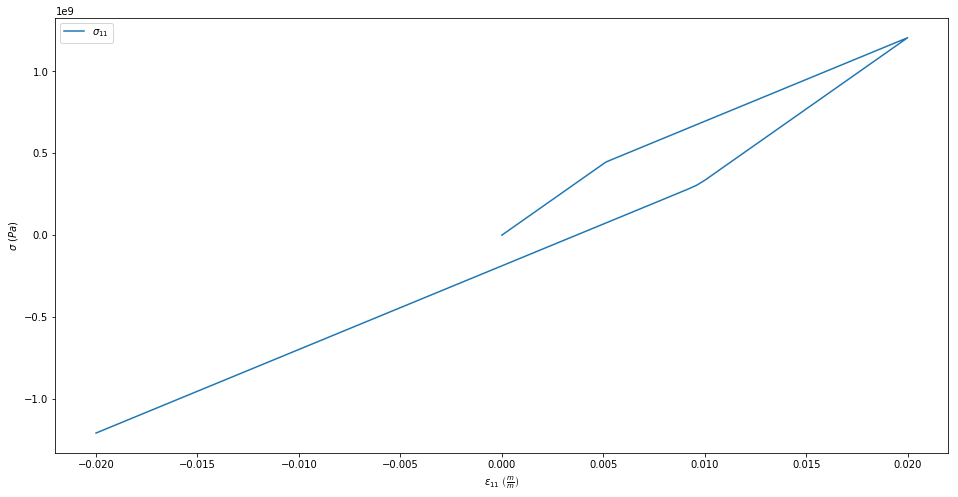

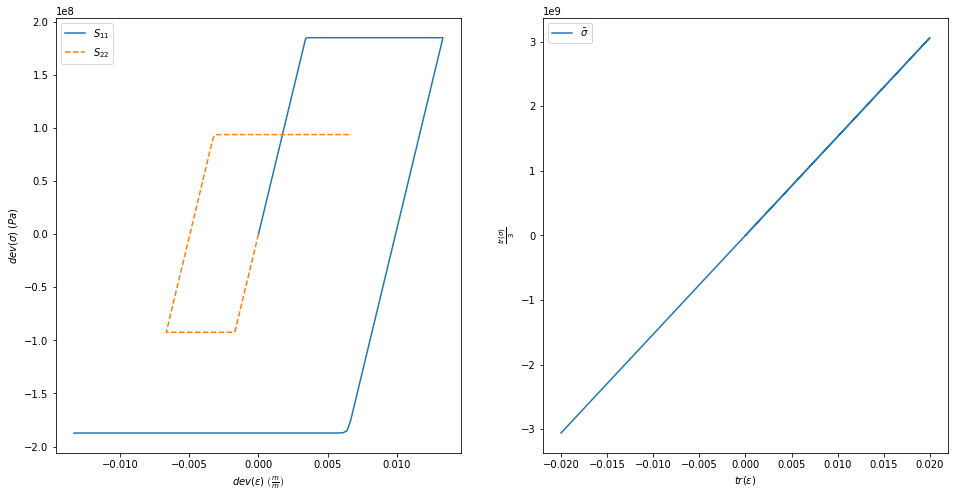

In [20]:
Evol = [sum(strain[:3,i]) for i in range(strain.shape[1])]

Iflat = np.array([1,1,1,0,0,0]).astype(float)

Edev = np.vstack([strain[:,i] - sum(strain[:3,i])/3*Iflat for i in range(strain.shape[1])]).T

sbar = [sum(stress[:3,i]) for i in range(stress.shape[1])]
S    = np.vstack([stress[:,i] - sum(stress[:3,i])/3*Iflat  for i in range(stress.shape[1])]).T

plt.figure(figsize=[16,8])
plt.plot(strain[0,:],stress[0,:],'-',label=r"$\sigma_{11}$")
plt.xlabel(r"$\epsilon_{11}\ \left(\frac{m}{m}\right)$")
plt.ylabel(r"$\sigma\ (Pa)$")
plt.legend()

plt.figure(figsize=[16,8])
plt.subplot(1,2,1)
plt.plot(Edev[0,:],S[0,:],'-',label=r"$S_{11}$")
plt.plot(Edev[1,:],S[1,:],'--',label=r"$S_{22}$")
plt.xlabel(r"$dev\left(\epsilon\right)\ \left(\frac{m}{m}\right)$")
plt.ylabel(r"$dev\left(\sigma\right)\ \left(Pa\right)$")
plt.legend()

plt.subplot(1,2,2)
plt.plot(Evol,sbar,label=r"$\bar{\sigma}$")
plt.xlabel(r"$tr\left(\epsilon\right)$")
plt.ylabel(r"$\frac{tr\left(\sigma\right)}{3}$")
plt.legend()
plt.show()

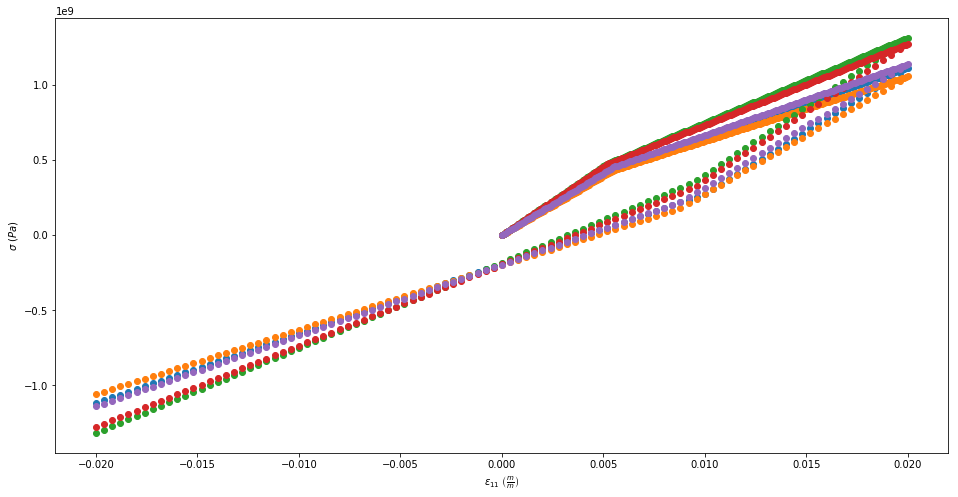

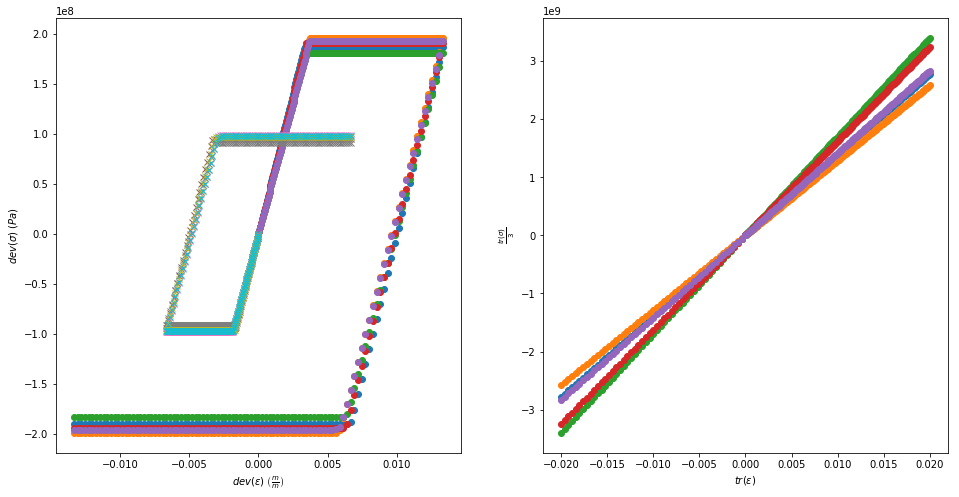

In [36]:
np.random.seed(123)

#Create noisy tests

#True values
Ktrue      = 69e9
mutrue     = 27e9
sigy_Ktrue = 276e6
mod_Ktrue  = 5e2
sigy_Htrue = 100e10
mod_Htrue  = 0.

#Create tests
ntests = 5

test_strains  = []
test_stresses = []

for _ in range(ntests):
    Kt      = (1 + np.random.normal(0,0.05))*Ktrue
    mut     = (1 + np.random.normal(0,0.05))*mutrue
    sigy_Kt = (1 + np.random.normal(0,0.05))*sigy_Ktrue
    mod_Kt  = (1 + np.random.normal(0,0.05))*mod_Ktrue
    sigy_Ht = (1 + np.random.normal(0,0.05))*sigy_Htrue
    mod_Ht  = (1 + np.random.normal(0,0.05))*mod_Htrue
    
    paramst = [Kt - (2*mut)/3., mut, 1, sigy_Kt, mod_Kt, 1, sigy_Ht, mod_Ht]
    
    result = driver(tt.tensor.as_tensor_variable(ts),tt.tensor.as_tensor_variable(strains),\
                    tt.tensor.as_tensor_variable(paramst),tt.tensor.as_tensor_variable(100))
    
    output = result.eval()
    
    test_stresses.append(output[:6,:])
    test_strains.append(output[6:,:])
    
Evols = [[sum(test_strains[n][:3,i]) for i in range(test_strains[n].shape[1])] for n in range(len(test_strains))]

Iflat = np.array([1,1,1,0,0,0]).astype(float)

Edevs = [np.vstack([test_strains[n][:,i] - sum(test_strains[n][:3,i])/3*Iflat for i in range(test_strains[n].shape[1])]).T for n in range(len(test_strains))]

sbars = [[sum(test_stresses[n][:3,i]) for i in range(test_stresses[n].shape[1])] for n in range(len(test_stresses))]
Ses   = [np.vstack([test_stresses[n][:,i] - sum(test_stresses[n][:3,i])/3*Iflat  for i in range(test_stresses[n].shape[1])]).T for n in range(len(test_stresses))]

plt.figure(figsize=[16,8])
[plt.plot(test_strains[n][0,:],test_stresses[n][0,:],'o') for n in range(ntests)]
plt.xlabel(r"$\epsilon_{11}\ \left(\frac{m}{m}\right)$")
plt.ylabel(r"$\sigma\ (Pa)$")
plt.legend()

plt.figure(figsize=[16,8])
plt.subplot(1,2,1)
[plt.plot(Edevs[n][0,:],Ses[n][0,:],'o') for n in range(ntests)]
[plt.plot(Edevs[n][1,:],Ses[n][1,:],'x') for n in range(ntests)]
plt.xlabel(r"$dev\left(\epsilon\right)\ \left(\frac{m}{m}\right)$")
plt.ylabel(r"$dev\left(\sigma\right)\ \left(Pa\right)$")
plt.legend()

plt.subplot(1,2,2)
[plt.plot(Evols[n],sbars[n],'o') for n in range(ntests)]
plt.xlabel(r"$tr\left(\epsilon\right)$")
plt.ylabel(r"$\frac{tr\left(\sigma\right)}{3}$")
plt.legend()
plt.show()

measured_results = np.hstack(test_stresses)

In [22]:
@tt.compile.ops.as_op(itypes=[tt.tensor.dvector, tt.tensor.dmatrix, tt.tensor.dscalar, tt.tensor.dscalar, tt.tensor.dvector, tt.tensor.dvector, tt.tensor.bscalar],otypes=[tt.tensor.dmatrix])
def evaluate(ts,strains,lambda_in,mu_in,pmod1_in,pmod2_in,pts_per_segment):
    """Define the driver which will run the material model"""
    
    pmod1 = [v for v in pmod1_in]
    pmod2 = [v for v in pmod2_in]
    
    #Inflate the incoming parameters
    lambda_in  = lambda_in*1e9
    mu_in      = mu_in*1e9
    pmod1[1]   = pmod1[1]*1e6
    pmod1[2]   = pmod1[2]*1e2
    pmod2[1]   = pmod2[1]*1e6
    pmod2[2]   = pmod2[2]*1e2
    
    #Reshape params
    params = [lambda_in, mu_in, pmod1, pmod2]
    #print params
    
    pts_per_segment = [pts_per_segment for _ in range(len(ts)-1)]
    
    #Set the location value
    i      = 0
    loc    = 1
    offset = 0
    
    #Set the previous values
    tp = ts[loc-1]
    
    #Set the time bounds
    tub = ts[loc]
    tlb = ts[loc-1]
       
    #Set the strain bounds
    eub = strains[loc]
    elb = strains[loc-1]
       
    #Initialize the state variables
    statevariables = [np.zeros([3,3]),0.,np.zeros([3,3])]
    
    #Initialize the storage vectors
    total_points = sum(pts_per_segment)+1
    stress_storage = np.zeros([6,total_points])
    strain_storage = np.zeros([6,total_points])
       
    #Begin strain incrementation
    while tp<ts[-1]:
        
        #Compute the ratio value
        r = (i+1.)/pts_per_segment[loc-1]
        
        #Compute the current value of time and strain
        t      = r*ts[loc] + (1.-r)*ts[loc-1]
        strain = r*strains[:,3*loc:3*(loc+1)] + (1.-r)*strains[:,3*(loc-1):3*loc]
       
        #Compute the stress at the increment
        stress,statevariables,converge_flag = get_stress(strain,params,statevariables)
    
        if(not converge_flag):
            break
    
        #Store the stress and strain
        stress_storage[:,offset+i+1] = map_tensor_to_vector(stress)[:]
        strain_storage[:,offset+i+1] = map_tensor_to_vector(strain)[:]
       
        #Increment i
        i += 1
        tp = t
       
    
        if(i>=pts_per_segment[loc-1]):
            i = 0
            offset += pts_per_segment[loc-1]
            loc += 1
    
    #plt.plot(stress_storage[0,:])
    #plt.show()
    #raise
    
    return np.hstack([stress_storage for _ in range(ntests)])

In [43]:
tstt       = tt.tensor.as_tensor_variable(ts)
straintt   = tt.tensor.as_tensor_variable(strains)
one        = tt.tensor.as_tensor_variable(1)
onehundred = tt.tensor.as_tensor_variable(100)

#plt.plot(stress_noise[0,:])

with pm.Model() as model:
    lamda  = pm.Uniform("lambda", lower=1,  upper=100)
    mu     = pm.Uniform("mu",     lower=1,  upper=100)
    sigy_K = pm.Uniform("sigy_K", lower=100, upper=400)
    mod_K  = pm.Uniform("mod_K",  lower=0.,  upper=10)
    sigy_H = pm.Uniform("sigy_H", lower=100, upper=400)
    mod_H  = pm.Uniform("mod_H",  lower=0.,  upper=10)
    
    #tt.printing.Print("lambda")(lamda)
    #tt.printing.Print("mu")(mu)
    #tt.printing.Print("sigy_K")(sigy_K)
    #tt.printing.Print("mod_K")(mod_K)
    #tt.printing.Print("sigy_H")(sigy_H)
    #tt.printing.Print("mod_H")(mod_H)
    
    y = pm.Deterministic("y",evaluate(tstt,straintt,lamda,mu,tt.tensor.stack([one, sigy_K, mod_K]),\
                                      tt.tensor.stack([one, sigy_H, mod_H]),onehundred))
    
    #print y.eval()
    
    sigma = pm.HalfNormal("sigma",sd=1.0)
    r = pm.Normal("r",mu=y,sd=sigma,observed=measured_results)
    
    step = pm.Metropolis()
    
    trace = pm.sample(400,njobs=1,chains=3,n_init=100,tune=100,random_seed=123,progressbar=True,model=model,step=step)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:06<00:00,  2.03it/s]


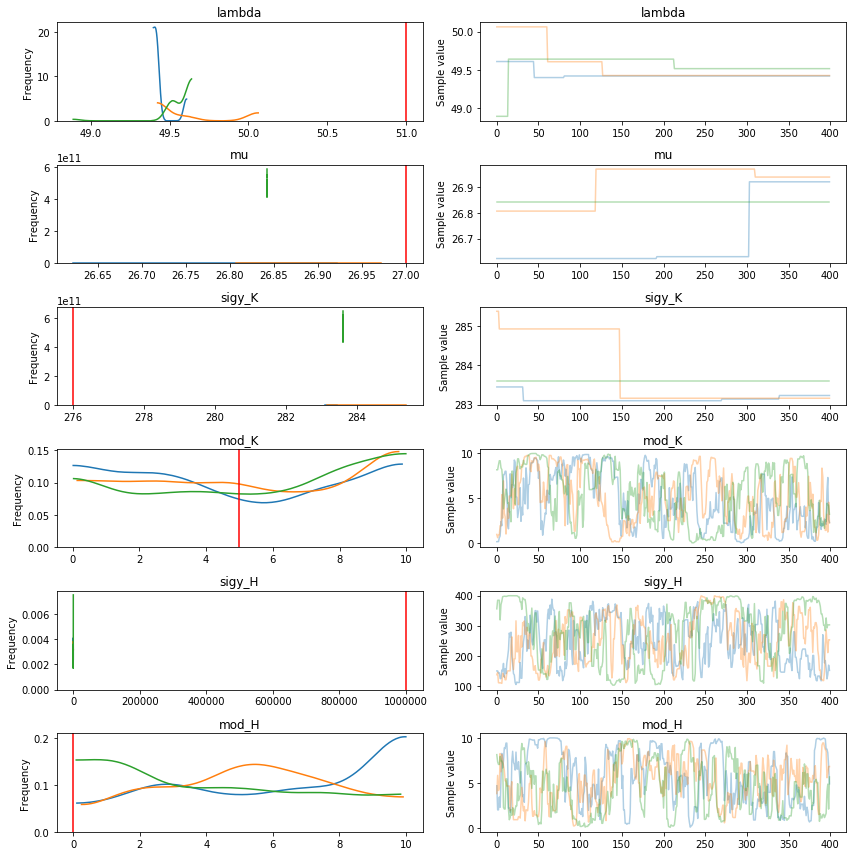

In [44]:
res = pm.traceplot(trace,["lambda","mu","sigy_K","mod_K","sigy_H","mod_H"])

shKt  = Ktrue/1e9
shmut = mutrue/1e9
ssyK  = sigy_Ktrue/1e6
smK   = mod_Ktrue/1e2
ssyH  = sigy_Htrue/1e6
smH   = mod_Htrue/1e2

res[0,0].plot([shKt-2*shmut/3.,shKt-2*shmut/3.], res[0,0].get_ylim(),'r-')
res[1,0].plot([shmut,shmut],                     res[1,0].get_ylim(),'r-')
res[2,0].plot([ssyK,ssyK],                       res[2,0].get_ylim(),'r-')
res[3,0].plot([smK,smK],                         res[3,0].get_ylim(),'r-')
res[4,0].plot([ssyH,ssyH],                       res[4,0].get_ylim(),'r-')
res[5,0].plot([smH,smH],                         res[5,0].get_ylim(),'r-')

In [45]:
pm.summary(trace,['lambda','mu','sigy_K','mod_K','sigy_H','mod_H'])


lambda:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  49.514           0.167            0.016            [49.418, 50.063]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  49.397         49.418         49.424         49.608         50.063


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  26.818           0.124            0.012            [26.622, 26.972]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  26.622         26.629         26.843         26.922         26.972


sigy_K:

  Mean             SD               MC Error         95% HPD interval
  --------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000246EE5F8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000029F9A588>]], dtype=object)

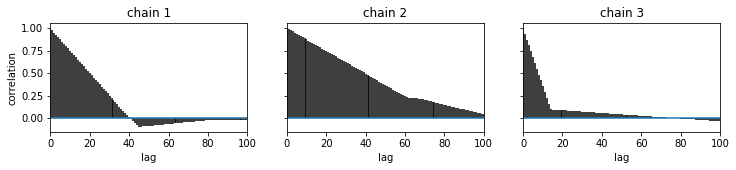

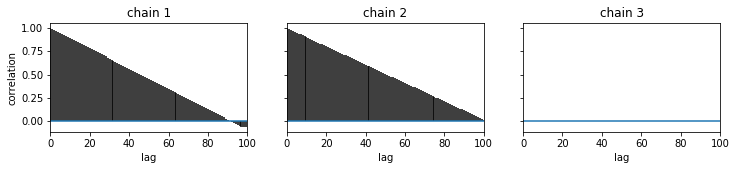

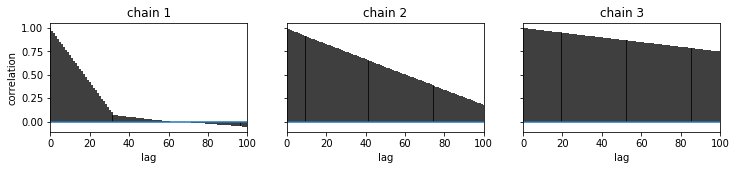

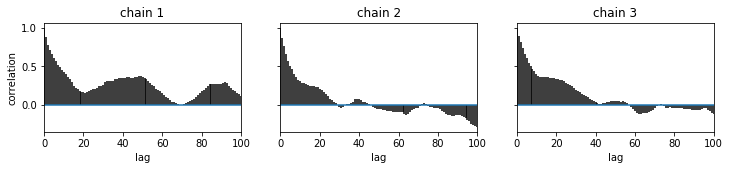

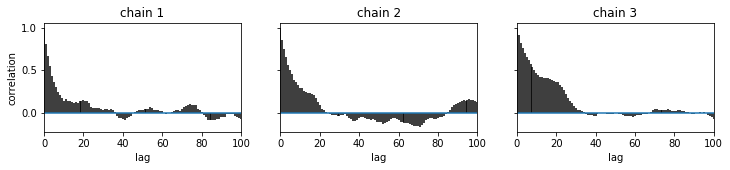

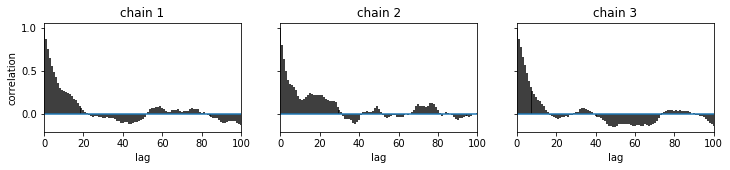

In [46]:
pm.autocorrplot(trace, varnames=['lambda'])
pm.autocorrplot(trace, varnames=['mu'])
pm.autocorrplot(trace, varnames=['sigy_K'])
pm.autocorrplot(trace, varnames=['mod_K'])
pm.autocorrplot(trace, varnames=['sigy_H'])
pm.autocorrplot(trace, varnames=['mod_H'])

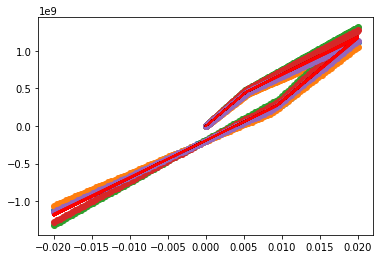

In [47]:
res = [plt.plot(test_strains[n][0,:],test_stresses[n][0,:],'o') for n in range(ntests)]
res = [plt.plot(test_strains[n][0,:],trace['y',::5][:,0,:301].T,'r-',alpha=0.3) for n in range(ntests)]